In [1]:
import pandas as pd
import numpy as np
from itertools import combinations 
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import re
from scipy import stats

# GENERAL AUXILIARY FUNCTIONS

In [2]:
def filter_data(raw_data, intensity_kind):
    '''return dataframe with first 6 columns and only one kind of intensity.'''
    df = raw_data.copy()
    colomns_to_filter = df.columns[6:]
    for col_name in colomns_to_filter:
        if intensity_kind not in col_name:
            df = df.drop(col_name, 1)
    return df 

def split_by_methods(df, intensity_kind, lysis_sign='C'):
    '''return 2 dataframes - 1 contains only lysis and 1 contains only epulse.'''
    epulse_df = df.copy()
    lysis_df = df.copy()
    for col_name in df.columns:
        res = re.search(intensity_kind, col_name)
        if res != None:
            res = re.search(lysis_sign, col_name)
            if res == None:  
                lysis_df = lysis_df.drop(col_name, 1)
            else:
                epulse_df = epulse_df.drop(col_name, 1)
    return epulse_df, lysis_df

def change_names_format(df):
    df.columns = ['{0}'.format(c.replace('_lysis','L').replace('_C','_').replace('BCC', 'Infiltrative' if '39' in c else 'Superficial' if '12' in c else 'Nodular')) for c in df.columns]
    return df

def order_data(raw_data,bcc,scc,bcc_scc,keratosis):
    '''order patients in spesific order for consistency and add the cancer type.'''
    patients = bcc.copy()
    patients.extend(scc)
    patients.extend(bcc_scc)
    patients.extend(keratosis)
    print(patients)
    df = raw_data.copy()
    df = df.reindex(columns=patients+['Gene names'])
    df.columns =['{0}{1}'.format('BCC ' if c in bcc else 'SCC ' if c in scc else 'SCC&BCC ' if c in bcc_scc else 'keratosis ' if c in keratosis else '', c) for c in df.columns]
    return df 

# READ AND ORDER THE DATASETS

# READ  DATASET

In [3]:
raw_data_lysis = pd.read_excel('RNA-HADAS-FIXED-NAMES.xlsx') 

In [4]:
intensity_kind = 'Intensity'
correlation_type = 'spearman' # spearman or pearson

In [5]:
df_lysis = change_names_format(raw_data_lysis.iloc[:,1:])
df_lysis['Gene names'] = raw_data_lysis['Unnamed: 0']

In [6]:
df_lysis

Superficial Intensity 12_1L  Superficial Intensity 12_3L  \
0                                0                            1   
1                                6                           46   
2                               13                            9   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
49470                            0                            0   
49471                            1                           27   
49472                            4                           19   
49473                            2                            4   
49474                            0                            0   

       Superficial Intensity 12_5L  Nodular Intensity 27_1L  \
0                                0                        0   
1                                6                       69   
2                                1                       13   
3                                0                        1   
4                                1                        0   
...                            ...                      ...   
49470                            0                        0   
49471                           19                       60   
49472                            2                       19   
49473                            2                       76   
49474                            0                        0   

       Nodular Intensity 27_3L  Nodular Intensity 27_5L  \
0                            0                        0   
1                           30                       42   
2                            8                        1   
3                            3                        1   
4                            0                        0   
...                        ...                      ...   
49470                        0                        1   
49471                       19                       11   
49472                       11                       13   
49473                       43                       25   
49474                        0                        0   

       Infiltrative Intensity 39_1L  Infiltrative Intensity 39_3L  \
0                                 0                             0   
1                                12                            41   
2                                 4                             8   
3                                 0                             1   
4                                 0                             0   
...                             ...                           ...   
49470                             0                             0   
49471                            43                            13   
49472                             5                            16   
49473                             6                            29   
49474                             0                             4   

       Infiltrative Intensity 39_5L       Gene names  
0                                 0  ENSG00000223972  
1                                13  ENSG00000227232  
2                                 2  ENSG00000278267  
3                                 0  ENSG00000243485  
4                                 1  ENSG00000238009  
...                             ...              ...  
49470                             0  ENSG00000276312  
49471                             5  ENSG00000275757  
49472                             3  ENSG00000278817  
49473                             9  ENSG00000277196  
49474                             0  ENSG00000278625  

[49475 rows x 10 columns]

In [7]:
df_lysis = df_lysis[['Gene names'] + [c for c in df_lysis.columns if c not in ['Gene names','Unnamed: 0']]]
df_lysis

Gene names  Superficial Intensity 12_1L  \
0      ENSG00000223972                            0   
1      ENSG00000227232                            6   
2      ENSG00000278267                           13   
3      ENSG00000243485                            0   
4      ENSG00000238009                            0   
...                ...                          ...   
49470  ENSG00000276312                            0   
49471  ENSG00000275757                            1   
49472  ENSG00000278817                            4   
49473  ENSG00000277196                            2   
49474  ENSG00000278625                            0   

       Superficial Intensity 12_3L  Superficial Intensity 12_5L  \
0                                1                            0   
1                               46                            6   
2                                9                            1   
3                                0                            0   
4                                0                            1   
...                            ...                          ...   
49470                            0                            0   
49471                           27                           19   
49472                           19                            2   
49473                            4                            2   
49474                            0                            0   

       Nodular Intensity 27_1L  Nodular Intensity 27_3L  \
0                            0                        0   
1                           69                       30   
2                           13                        8   
3                            1                        3   
4                            0                        0   
...                        ...                      ...   
49470                        0                        0   
49471                       60                       19   
49472                       19                       11   
49473                       76                       43   
49474                        0                        0   

       Nodular Intensity 27_5L  Infiltrative Intensity 39_1L  \
0                            0                             0   
1                           42                            12   
2                            1                             4   
3                            1                             0   
4                            0                             0   
...                        ...                           ...   
49470                        1                             0   
49471                       11                            43   
49472                       13                             5   
49473                       25                             6   
49474                        0                             0   

       Infiltrative Intensity 39_3L  Infiltrative Intensity 39_5L  
0                                 0                             0  
1                                41                            13  
2                                 8                             2  
3                                 1                             0  
4                                 0                             1  
...                             ...                           ...  
49470                             0                             0  
49471                            13                             5  
49472                            16                             3  
49473                            29                             9  
49474                             4                             0  

[49475 rows x 10 columns]

# HEATMAPS  WITH ALL  PROTEINS

## BCC

In [8]:
df_lysis = df_lysis.fillna(0)

In [9]:
df_lysis.iloc[:,1:]

Superficial Intensity 12_1L  Superficial Intensity 12_3L  \
0                                0                            1   
1                                6                           46   
2                               13                            9   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
49470                            0                            0   
49471                            1                           27   
49472                            4                           19   
49473                            2                            4   
49474                            0                            0   

       Superficial Intensity 12_5L  Nodular Intensity 27_1L  \
0                                0                        0   
1                                6                       69   
2                                1                       13   
3                                0                        1   
4                                1                        0   
...                            ...                      ...   
49470                            0                        0   
49471                           19                       60   
49472                            2                       19   
49473                            2                       76   
49474                            0                        0   

       Nodular Intensity 27_3L  Nodular Intensity 27_5L  \
0                            0                        0   
1                           30                       42   
2                            8                        1   
3                            3                        1   
4                            0                        0   
...                        ...                      ...   
49470                        0                        1   
49471                       19                       11   
49472                       11                       13   
49473                       43                       25   
49474                        0                        0   

       Infiltrative Intensity 39_1L  Infiltrative Intensity 39_3L  \
0                                 0                             0   
1                                12                            41   
2                                 4                             8   
3                                 0                             1   
4                                 0                             0   
...                             ...                           ...   
49470                             0                             0   
49471                            43                            13   
49472                             5                            16   
49473                             6                            29   
49474                             0                             4   

       Infiltrative Intensity 39_5L  
0                                 0  
1                                13  
2                                 2  
3                                 0  
4                                 1  
...                             ...  
49470                             0  
49471                             5  
49472                             3  
49473                             9  
49474                             0  

[49475 rows x 9 columns]

In [10]:
df_lysis = df_lysis[['Gene names','Infiltrative Intensity 39_1L','Infiltrative Intensity 39_3L','Infiltrative Intensity 39_5L'
                    ,'Superficial Intensity 12_1L','Superficial Intensity 12_3L','Superficial Intensity 12_5L',
                    'Nodular Intensity 27_1L','Nodular Intensity 27_3L','Nodular Intensity 27_5L']]
df_lysis.columns = ['{0}'.format(c.replace(' Intensity', '')) for c in df_lysis.columns]

df_lysis

Gene names  Infiltrative 39_1L  Infiltrative 39_3L  \
0      ENSG00000223972                   0                   0   
1      ENSG00000227232                  12                  41   
2      ENSG00000278267                   4                   8   
3      ENSG00000243485                   0                   1   
4      ENSG00000238009                   0                   0   
...                ...                 ...                 ...   
49470  ENSG00000276312                   0                   0   
49471  ENSG00000275757                  43                  13   
49472  ENSG00000278817                   5                  16   
49473  ENSG00000277196                   6                  29   
49474  ENSG00000278625                   0                   4   

       Infiltrative 39_5L  Superficial 12_1L  Superficial 12_3L  \
0                       0                  0                  1   
1                      13                  6                 46   
2                       2                 13                  9   
3                       0                  0                  0   
4                       1                  0                  0   
...                   ...                ...                ...   
49470                   0                  0                  0   
49471                   5                  1                 27   
49472                   3                  4                 19   
49473                   9                  2                  4   
49474                   0                  0                  0   

       Superficial 12_5L  Nodular 27_1L  Nodular 27_3L  Nodular 27_5L  
0                      0              0              0              0  
1                      6             69             30             42  
2                      1             13              8              1  
3                      0              1              3              1  
4                      1              0              0              0  
...                  ...            ...            ...            ...  
49470                  0              0              0              1  
49471                 19             60             19             11  
49472                  2             19             11             13  
49473                  2             76             43             25  
49474                  0              0              0              0  

[49475 rows x 10 columns]

# SHORTCUT PATIENTS NAMES.

In [11]:
new_columns = []
for col in df_lysis.columns:
    new_col = col.replace("Infiltrative", "I")
    new_col = new_col.replace("Superficial", "S")
    new_col = new_col.replace("Nodular", "N")
    new_col = new_col.replace("1L", "I")
    new_col = new_col.replace("3L", "II")
    new_col = new_col.replace("5L", "III")
    new_col = new_col.replace("39", "1")
    new_col = new_col.replace("12", "4")    
    new_col = new_col.replace("27", "7")
    new_col += ' '
    #new_col = new_col.replace(" ", "")
    new_columns.append(new_col)
df_lysis.columns = new_columns    
display(df_lysis)

Gene names   I 1_I   I 1_II   I 1_III   S 4_I   S 4_II   S 4_III   \
0      ENSG00000223972       0        0         0       0        1         0   
1      ENSG00000227232      12       41        13       6       46         6   
2      ENSG00000278267       4        8         2      13        9         1   
3      ENSG00000243485       0        1         0       0        0         0   
4      ENSG00000238009       0        0         1       0        0         1   
...                ...     ...      ...       ...     ...      ...       ...   
49470  ENSG00000276312       0        0         0       0        0         0   
49471  ENSG00000275757      43       13         5       1       27        19   
49472  ENSG00000278817       5       16         3       4       19         2   
49473  ENSG00000277196       6       29         9       2        4         2   
49474  ENSG00000278625       0        4         0       0        0         0   

       N 7_I   N 7_II   N 7_III   
0           0        0         0  
1          69       30        42  
2          13        8         1  
3           1        3         1  
4           0        0         0  
...       ...      ...       ...  
49470       0        0         1  
49471      60       19        11  
49472      19       11        13  
49473      76       43        25  
49474       0        0         0  

[49475 rows x 10 columns]

# SHOW AMOUNT OF GENES WITH INTENSITY > 0 IN EACH SAMPLE.

In [12]:
a =df_lysis.iloc[:,1:].copy()
a[a>0]=1
a.sum(0)

I 1_I       34484
I 1_II      37636
I 1_III     31584
S 4_I       26552
S 4_II      30814
S 4_III     27535
N 7_I       36881
N 7_II      33066
N 7_III     32934
dtype: int64

# HEATMAP VISUALIZATION

In [13]:
from scipy import stats
def get_spearman_pearson_corr_matrix(df_bcc3):
    mask_spearman=np.zeros((df_bcc3.shape[1],df_bcc3.shape[1]))
    
    mask_pearson = np.zeros((df_bcc3.shape[1],df_bcc3.shape[1]))
    
    df = pd.DataFrame(index=df_bcc3.columns,columns=df_bcc3.columns,dtype=float)
    for i in range(df_bcc3.shape[1]):
        for j in range(df_bcc3.shape[1]):
            if i < j:
                corr, p_val = stats.pearsonr(df_bcc3.iloc[:,i],df_bcc3.iloc[:,j])
                mask_pearson[j,i]= 1
            elif i > j:
                corr, p_val = stats.spearmanr(df_bcc3.iloc[:,i],df_bcc3.iloc[:,j])
                mask_spearman[j,i]=1 
            else:
                corr = 0.7
            
            df.iloc[j,i] = corr
    return df, mask_pearson, mask_spearman


df_corr_bcc3, mask_pearson, mask_spearman = get_spearman_pearson_corr_matrix(df_lysis.iloc[:,1:])
sns.set(font_scale=9)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

sns.set(font_scale=37)

# Make data for display
red = np.ma.masked_where(mask_pearson,a=df_corr_bcc3)

blue = np.ma.masked_where(mask_spearman,a=df_corr_bcc3)


# Make a side-by-side plot
fig, ax = plt.subplots()
redmesh = ax.pcolormesh(red, cmap='Purples')
bluemesh = ax.pcolormesh(blue, cmap='Greens')


# Make things a touch fancier
ax.tick_params(axis='x', labelrotation=90)
short_col_names = [col_name.replace('BCC ','').replace('intensity ','').replace('LFQ ','').replace('L','  ') for col_name in df_lysis.iloc[:,1:].columns]
ax.set(xticks=np.arange(1,df_lysis.iloc[:,1:].shape[1]+1)-0.5,
       yticks=np.arange(1,df_lysis.iloc[:,1:].shape[1]+1)-0.5,
       xticklabels=short_col_names,
       yticklabels=short_col_names)

ax.set_title('Spearman and Pearson Heatmap', y=1.07,size=400)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.tick_params(direction='out')

# Add dual colorbars
fig.subplots_adjust(bottom=0.05, right=0.78, top=0.88)
cbar = fig.colorbar(redmesh, cax=fig.add_axes([0.81, 0.05, 0.04, 0.83]))
cbar.ax.text(0.55, 0.11, 'spearman', rotation=90, ha='center', va='center',
             transform=cbar.ax.transAxes, size=300,color='gray')
cbar = fig.colorbar(bluemesh, cax=fig.add_axes([0.9, 0.05, 0.04, 0.83]))
cbar.ax.text(0.55, 0.1, 'pearson', rotation=90, ha='center', va='center',
             transform=cbar.ax.transAxes, size=300,color='gray')



# Make the grouping clearer
ax.grid(axis='x', ls='-', color='gray', which='minor')
ax.grid(axis='y', ls=':', color='gray')
ax.invert_yaxis()

color_treshold = df_corr_bcc3.mean().mean()
for i in range(df_lysis.iloc[:,1:].shape[1]):
    for j in range(df_lysis.iloc[:,1:].shape[1]):
        text = ax.text(j+0.5, i + 0.5, '{:.2f}'.format(df_corr_bcc3.iloc[i, j]),
                       ha="center", va="center" , color='white' if df_corr_bcc3.iloc[i, j] > 0.84 else 'black')
fig.set_size_inches((350,200))
plt.show()

# HISTOGRAMS

# GET EACH SUBGROUP CORRELATIONS AS AN ARRAY

In [15]:
def get_inter_intra_values(df_corr):
    inter_hist = []
    intra_hist = []
    i=0
    while i < df_corr.shape[0]:
        sample_name = df_corr.index[i]
        for intra_end in [3,2,1]:
            intra_hist.extend(df_corr.iloc[i, (i + 1):(i + intra_end)])
            inter_hist.extend(df_corr.iloc[i, (i + intra_end):])
            i += 1
    display('inter histogram len:',len(inter_hist))
    display('intra histogram len:',len(intra_hist))
    return inter_hist,intra_hist

df_corr = df_corr_bcc3

if correlation_type == 'pearson':
    df_corr = df_lysis.iloc[:,1:].corr('pearson')

display(df_corr)
sample_amount = df_corr.shape[0]
inter_hist_i,intra_hist_i = get_inter_intra_values(df_corr.iloc[:sample_amount//3, :sample_amount//3])
inter_hist_s,intra_hist_s = get_inter_intra_values(df_corr.iloc[sample_amount//3:2*sample_amount//3, sample_amount//3:2*sample_amount//3])
inter_hist_n,intra_hist_n = get_inter_intra_values(df_corr.iloc[2*sample_amount//3:, 2*sample_amount//3:])

inter_hist_s_i = df_corr.iloc[:sample_amount//3, sample_amount//3: 2 * sample_amount//3].values.flatten()
inter_hist_i_n = df_corr.iloc[:sample_amount//3, 2* sample_amount//3 : 3 * sample_amount//3].values.flatten()
inter_hist_s_n = df_corr.iloc[sample_amount//3:2*sample_amount//3, 2* sample_amount//3 : 3 * sample_amount//3].values.flatten()

labels_inter = []
inter_hist = []
inter_hist.extend(inter_hist_i)
labels_inter.extend(len(inter_hist_i)*['inter patient i'])

inter_hist.extend(inter_hist_s)
labels_inter.extend(len(inter_hist_s)*['inter patient s'])

inter_hist.extend(inter_hist_n)
labels_inter.extend(len(inter_hist_n)*['inter patient n'])

inter_hist.extend(inter_hist_s_i)
labels_inter.extend(len(inter_hist_s_i)*['inter patient s-i'])

inter_hist.extend(inter_hist_i_n)
labels_inter.extend(len(inter_hist_i_n)*['inter patient i-n'])

inter_hist.extend(inter_hist_s_n)
labels_inter.extend(len(inter_hist_s_n)*['inter patient s-n'])

labels_intra =[]
intra_hist = []
intra_hist.extend(intra_hist_i)
labels_intra.extend(len(intra_hist_i)*['blue'])

intra_hist.extend(intra_hist_s)
labels_intra.extend(len(intra_hist_s)*['yellow'])

intra_hist.extend(intra_hist_n)
labels_intra.extend(len(intra_hist_n)*['black'])
hists_df = pd.DataFrame()



I 1_I    I 1_II   I 1_III     S 4_I    S 4_II   S 4_III   \
I 1_I     0.700000  0.904171  0.895910  0.844784  0.842938  0.845352   
I 1_II    0.682488  0.700000  0.899432  0.821270  0.834410  0.814092   
I 1_III   0.843328  0.702149  0.700000  0.844910  0.849733  0.837604   
S 4_I     0.617839  0.584836  0.737157  0.700000  0.889167  0.875699   
S 4_II    0.750872  0.613101  0.799360  0.845672  0.700000  0.877782   
S 4_III   0.516861  0.190002  0.210589  0.256110  0.258328  0.700000   
N 7_I     0.725104  0.640972  0.806554  0.562408  0.693732  0.189498   
N 7_II    0.670814  0.813817  0.774005  0.743793  0.737798  0.202830   
N 7_III   0.477028  0.502843  0.695830  0.819753  0.638387  0.193490   

            N 7_I    N 7_II   N 7_III   
I 1_I     0.844325  0.854456  0.870449  
I 1_II    0.874126  0.867380  0.866713  
I 1_III   0.852624  0.866908  0.878231  
S 4_I     0.803467  0.823210  0.851515  
S 4_II    0.823537  0.837877  0.866373  
S 4_III   0.800601  0.817209  0.851836  
N 7_I     0.700000  0.932313  0.907776  
N 7_II    0.810413  0.700000  0.913544  
N 7_III   0.462924  0.656229  0.700000

'inter histogram len:'

0

'intra histogram len:'

3

'inter histogram len:'

0

'intra histogram len:'

3

'inter histogram len:'

0

'intra histogram len:'

3

In [16]:
intra_hist

[0.9041705003852778,
 0.8959104658256304,
 0.8994320178407359,
 0.889166972062544,
 0.8756987462811151,
 0.8777819834062411,
 0.9323125511092274,
 0.9077761607507417,
 0.9135444752571832]

# BASIC HISTOGRAM VISUALIZATION.

[0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84 0.86
 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


/Users/ilaigenishmac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


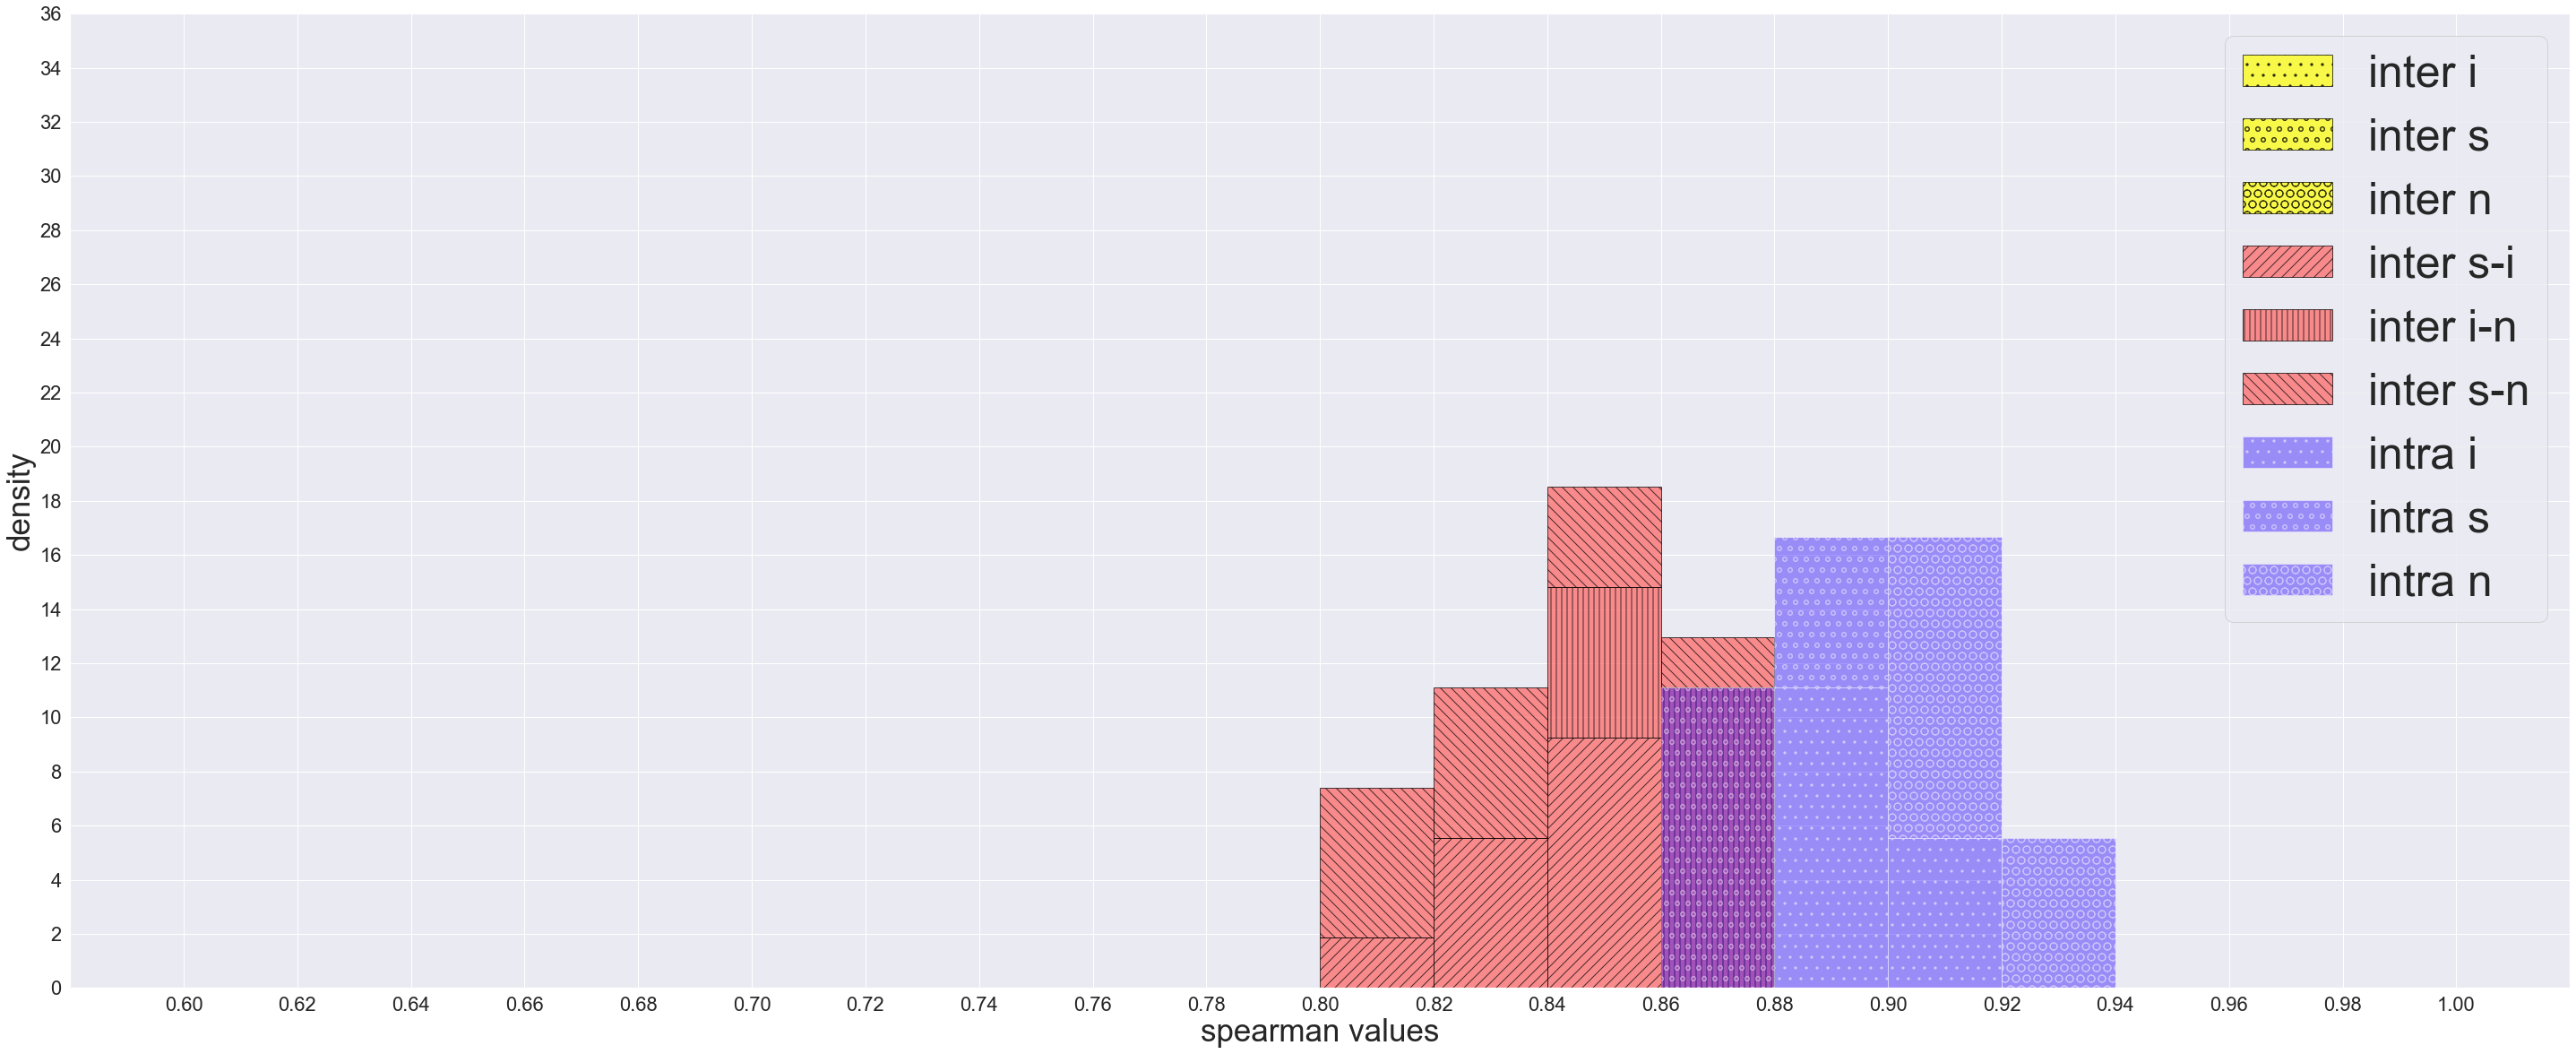

In [17]:
bins=np.histogram(np.hstack((inter_hist,intra_hist)), bins=20,range=(0.6,1))[1] #get the bin edges
print(bins)
sns.set(font_scale=2)
plt.figure(figsize=(50,20))

inter_hist_ = np.array([inter_hist_i,inter_hist_s,inter_hist_n,inter_hist_s_i,inter_hist_i_n,inter_hist_s_n]).T

n, bins, patches = plt.hist(inter_hist_, density=True, bins =bins, stacked=True, alpha = 0.7,
         color=['yellow','yellow','yellow','#FF6161', '#FF6161','#FF6161'],
         label=["inter i","inter s","inter n","inter s-i","inter i-n","inter s-n"],
         hatch = "O",edgecolor='black')

hatches = [ '.', 'o', 'O','//','||', '\\\\']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)
        
n, bins, patches = plt.hist([intra_hist_i,intra_hist_s,intra_hist_n], 
         density=True,bins =bins,stacked=True, alpha = 0.4,
         color=['#2200FF','#2200FF','#2200FF'],
         label=["intra i","intra s","intra n"],
         hatch = "x",edgecolor='white')

hatches = [ '.', 'o', 'O']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)

plt.legend(prop={'size': 50})
plt.xlabel(f'{correlation_type} values',size = 35)
plt.ylabel('density',size = 35)

if correlation_type == 'spearman':
    plt.xticks(np.linspace(start=0.6,stop=1.0,num=21,endpoint=True))
    plt.yticks(np.linspace(start=0,stop=36,num=19,endpoint=True))


if correlation_type == 'pearson':
    plt.xticks(np.linspace(start=0.3,stop=1.0,num=36,endpoint=True))
    plt.yticks(np.linspace(start=0,stop=120,num=31,endpoint=True))

plt.show()


# FINAL HISTOGRAM VISUALIZATION.

# HISTOGRAM VISUALIZATION AUXILIARY FUNCTIONS

In [18]:
def get_hist(values,bins=40, plot_range=(0.6,1),weights=None):
    """
    given array of correlations (values) the function split the correlations
    to bins and amount of correlation in each bin.
    retrun: two dim array - hist[0][i] the amount of values in bin i, hist[1][i]- the bin start (bin end = hist[1][i+1]).
    """
    if weights is None:
        res = np.histogram(values, bins=bins,range=plot_range)
    else:
        res = np.histogram(values, bins=bins,range=plot_range,weights=weights)
        
    hist = []
    hist.append(np.array([int(i) for i in res[0]]))
    hist.append(np.array([float(i) for i in res[1]]))
    
    return hist

def get_norm_denominator(hist1,hist2,hist3,bins_width):
    """normalize the histogram of intra patients"""
    denominator=hist1+hist2+hist3
    print('aaaaa', np.array([1 if i == 0 else i for i in denominator]))
    res = sum(denominator)#*bins_width
    return res

def get_norm_denominator6(hist1,hist2,hist3,hist4,hist5,hist6,bins_width):
    """normalize the histogram of inter patients"""
    denominator = hist1+hist2+hist3+hist4+hist5+hist6
    print('aaaaa', np.array([1 if i == 0 else i for i in denominator]))
    res = sum(denominator)
    return res

def get_baiysian(group,denominator):
    res=[]
    print(group,denominator)
    for g,d in zip (group,denominator):
        if g==d==0:
            res.append(0.5)
        else:
            res.append(g/d)
    return res
    

aaaaa [ 1  1  1  4  6 10  7  1  1  1  1  1  1]
aaaaa [1 1 1 1 1 1 2 3 3 1 1 1 1]
[0.         0.         0.         0.14814815 0.22222222 0.37037037
 0.25925926 0.         0.         0.         0.         0.
 0.        ] [0.0, 0.0, 0.0, 0.14814814814814814, 0.2222222222222222, 0.37037037037037035, 0.48148148148148145, 0.3333333333333333, 0.3333333333333333, 0.1111111111111111, 0.0, 0.0, 0.0]


bins bin height - inter patients bin height - intra patient  \
0   [0.74, 0.76)                           0                          0   
1   [0.76, 0.78)                           0                          0   
2   [0.78, 0.80)                           0                          0   
3   [0.80, 0.82)                       0.148                          0   
4   [0.82, 0.84)                       0.222                          0   
5   [0.84, 0.86)                        0.37                          0   
6   [0.86, 0.88)                       0.259                      0.222   
7   [0.88, 0.90)                           0                      0.333   
8   [0.90, 0.92)                           0                      0.333   
9   [0.92, 0.94)                           0                      0.111   
10  [0.94, 0.96)                           0                          0   
11  [0.96, 0.98)                           0                          0   
12  [0.98, 1.00)                           0                          0   
13      [1,1.02)                           0                          0   

   p(corr ∈ inter)  
0              0.5  
1              0.5  
2              0.5  
3                1  
4                1  
5                1  
6            0.538  
7                0  
8                0  
9                0  
10             0.5  
11             0.5  
12             0.5  
13             0.5

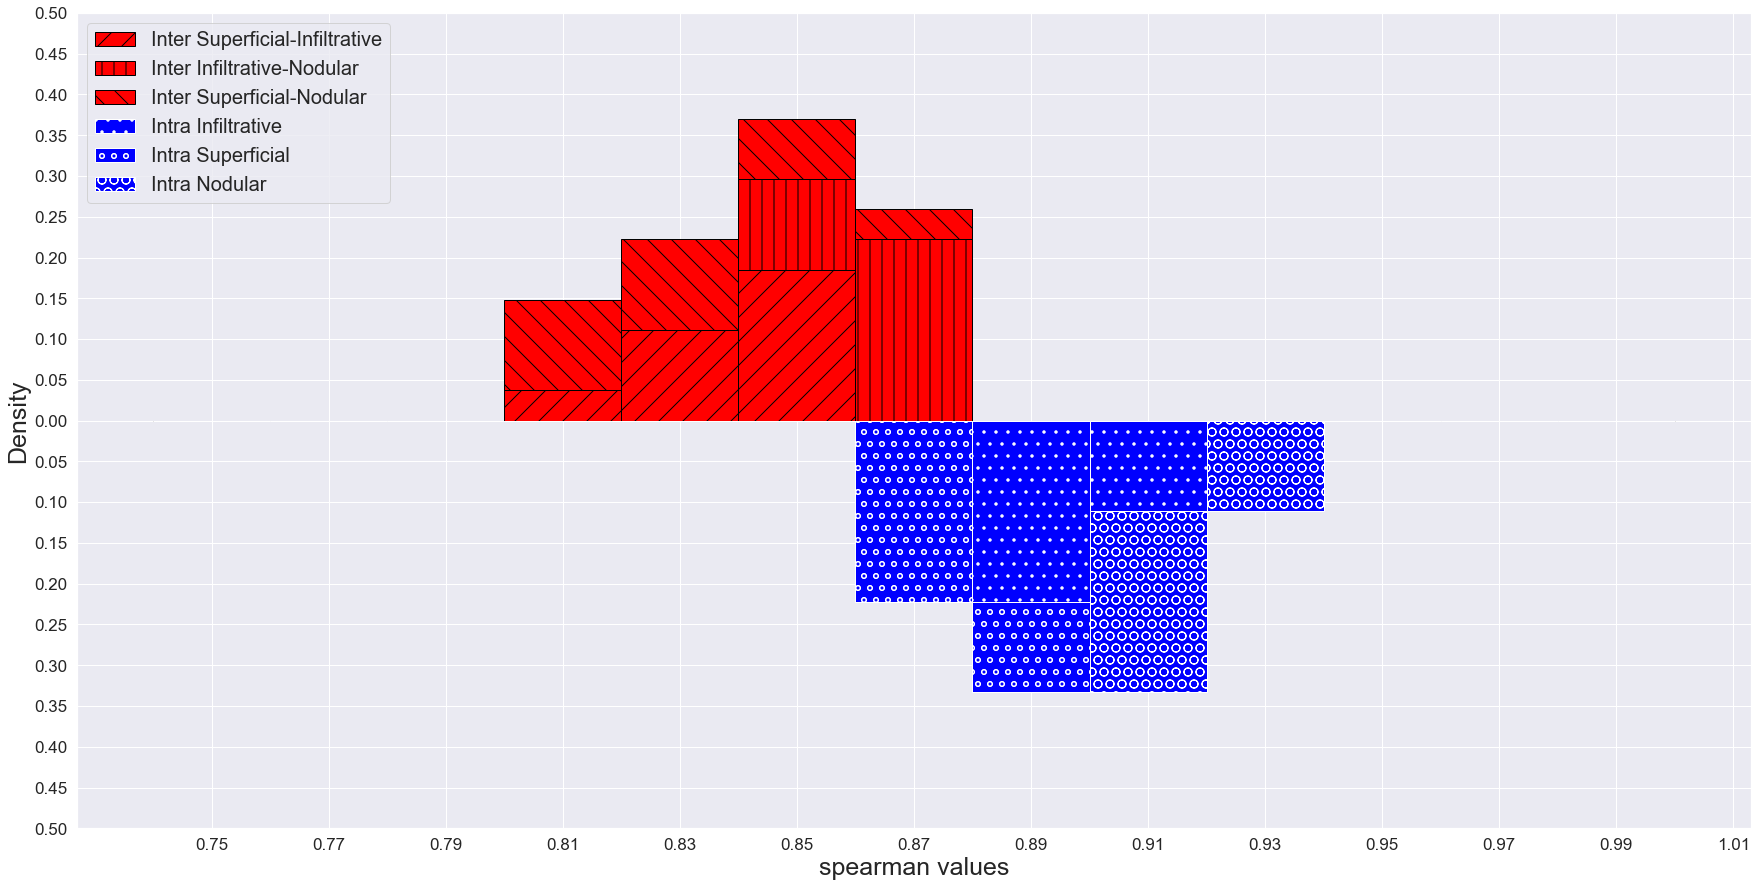

In [19]:
y1 = np.array(inter_hist_i)
y2 = np.array(inter_hist_s)
y3 = np.array(inter_hist_n)
y4 = np.array(inter_hist_s_i)
y5 = np.array(inter_hist_i_n)
y6 = np.array(inter_hist_s_n)
y7 = np.array(intra_hist_i)
y8 = np.array(intra_hist_s)
y9 = np.array(intra_hist_n)

plt.figure(figsize=(30,15))
barWidth=0.02
bins_width= 0.02


if correlation_type == 'spearman':
    bins_number = 13
    plot_start_range =0.74


if correlation_type == 'pearson':
    bins_number = 42
    plot_start_range =0.16


hist_inter_i = get_hist(y1, bins=bins_number,plot_range=(plot_start_range,1))
hist_inter_s = get_hist(y2, bins=bins_number,plot_range=(plot_start_range,1))
hist_inter_n = get_hist(y3, bins=bins_number,plot_range=(plot_start_range,1))

hist_inter_s_i = get_hist(y4, bins=bins_number,plot_range=(plot_start_range,1))
hist_inter_i_n = get_hist(y5, bins=bins_number,plot_range=(plot_start_range,1))
hist_inter_s_n = get_hist(y6, bins=bins_number,plot_range=(plot_start_range,1))


denominator6 = get_norm_denominator6(hist_inter_i[0],hist_inter_s[0],hist_inter_n[0],
                                     hist_inter_s_i[0],hist_inter_i_n[0],hist_inter_s_n[0],bins_width)
height_i =hist_inter_i[0]/denominator6
height_s =hist_inter_s[0]/denominator6
height_n =hist_inter_n[0]/denominator6

height_inter = (hist_inter_i[0] + hist_inter_s[0] + hist_inter_n[0] + hist_inter_s_i[0] + hist_inter_i_n[0] + hist_inter_s_n[0])/\
               (hist_inter_i[0] + hist_inter_s[0] + hist_inter_n[0] + hist_inter_s_i[0] + hist_inter_i_n[0] + hist_inter_s_n[0]).sum()

height_s_i =hist_inter_s_i[0]/denominator6
height_i_n =hist_inter_i_n[0]/denominator6
height_s_n =hist_inter_s_n[0]/denominator6


start = height_i+height_s + height_n
plt.bar(x=hist_inter_s_i[1][:-1] + bins_width/2,
        height=height_s_i,
        width=barWidth,
        bottom = start,
        label='Inter Superficial-Infiltrative',
        color='red', 
        edgecolor='black',
        linewidth=1,
        hatch='/')


plt.bar(x=hist_inter_i_n[1][:-1] + bins_width/2,
        height=height_i_n,
        bottom= start + height_s_i,
        width=barWidth, 
        label='Inter Infiltrative-Nodular',
        color='red', 
        edgecolor='black',
        linewidth=1,
        hatch='|')


plt.bar(x=hist_inter_s_n[1][:-1] + bins_width/2,
        height=height_s_n,
        bottom=start + height_s_i + height_i_n,
        width=barWidth, 
        label='Inter Superficial-Nodular',
        color='red', 
        edgecolor='black',
        linewidth=1,
        hatch='\\')

hist_intra_i = get_hist(y7, bins=bins_number,plot_range=(plot_start_range,1))
hist_intra_s = get_hist(y8, bins=bins_number,plot_range=(plot_start_range,1))
hist_intra_n = get_hist(y9, bins=bins_number,plot_range=(plot_start_range,1))

height_intra = (hist_intra_i[0] + hist_intra_s[0] + hist_intra_n[0])/(hist_intra_i[0] + hist_intra_s[0] + hist_intra_n[0]).sum()

denominator3 = get_norm_denominator(hist_intra_i[0],hist_intra_s[0],hist_intra_n[0],bins_width)

height_i =hist_intra_i[0]/denominator3
height_s =hist_intra_s[0]/denominator3
height_n =hist_intra_n[0]/denominator3

plt.bar(x=hist_intra_i[1][:-1] + bins_width/2 ,
        height=-height_i,
        width=barWidth, 
        label='Intra Infiltrative',
        color='blue', 
        edgecolor='white',
        linewidth=1,
        hatch='.')


plt.bar(x=hist_intra_s[1][:-1] + bins_width/2,
        height=-height_s ,
        bottom=-height_i,
        width=barWidth, 
        label='Intra Superficial',
        color='blue', 
        edgecolor='white',
        linewidth=1,
        hatch='o')


plt.bar(x=hist_intra_n[1][:-1] + bins_width/2,
        height=-height_n,
        bottom=-height_i-height_s,
        width=barWidth, 
        label='Intra Nodular',
        color='blue', 
        edgecolor='white',
        linewidth=1,
        hatch='O')

ticks_names = ["[{:.2f}, {:.2f})".format(float(hist_inter_i[1][i-1]),float(hist_inter_i[1][i])) for i in range(1,len(hist_inter_i[1]))]
ticks_names.append(f'[1,{1+bins_width})')

ax = plt.gca()
ax.set_xticks(ticks = hist_inter_i[1] + bins_width/2)
ax.tick_params(labelsize=17)

plt.xlabel(f'{correlation_type} values',size = 25)
plt.ylabel('Density',size = 25)

display(pd.DataFrame([ticks_names,
                      np.append(height_inter,[0]).round(3),
                      np.append(height_intra,[0]).round(3),
                      (np.append(get_baiysian(height_inter,[a+b for a,b in zip(height_intra,height_inter)]),[0.5])).round(3)],
                    index = ['bins','bin height - inter patients','bin height - intra patient', r'p(corr ∈ inter)']).T)



plt.legend(prop={'size': 20},loc='upper left')

if correlation_type == 'spearman':
    sns.set(font_scale=1.4)
    ax.set_yticks(ticks = np.linspace(-0.5, 0.5, 21))
    ax.set_yticklabels(['{:.2f}'.format(abs(x)) for x in np.linspace(-0.5, 0.5, 21)],rotation=0)


if correlation_type == 'pearson':
    sns.set(font_scale=0.75)
    ax.set_yticks(ticks = np.linspace(-0.3,0.3,13))
    ax.set_yticklabels(['{:.2f}'.format(abs(x)) for x in np.linspace(-0.3,0.3,13)], rotation=0)


plt.show()

# BAYSIAN MODEL ERROR.

In [20]:
print(hist_inter_s_i[0] + hist_inter_i_n[0] + height_s_n[0], hist_inter_n[1])

print(hist_intra_n[0] + hist_intra_i[0] + hist_intra_s[0], hist_intra_n[1])


[0. 0. 0. 1. 3. 8. 6. 0. 0. 0. 0. 0. 0.] [0.74 0.76 0.78 0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]
[0 0 0 0 0 0 2 3 3 1 0 0 0] [0.74 0.76 0.78 0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


In [21]:
inter_hist_count = (hist_inter_s_i[0] + hist_inter_i_n[0] + height_s_n[0], hist_inter_n[1])
intra_hist_count = (hist_intra_n[0] + hist_intra_i[0] + hist_intra_s[0], hist_intra_n[1])

total = inter_hist_count[0] + intra_hist_count[0]
total[total==0] =1
prior_inter = inter_hist_count[0] / total
p_inter = inter_hist_count[0]/inter_hist_count[0].sum()

prior_intra = intra_hist_count[0]/ total
p_intra = intra_hist_count[0]/intra_hist_count[0].sum()

a = pd.DataFrame([inter_hist_count[0],prior_inter,p_inter,prior_inter*p_inter,intra_hist_count[0],prior_intra,p_intra,prior_intra*p_intra],index = ['bin count inter','prior-inter','p-inter','prior-inter*p-inter','bin count intra','prior-intra','p-intra','prior-intra*p-intra']).T
a


bin count inter  prior-inter   p-inter  prior-inter*p-inter  \
0               0.0         0.00  0.000000             0.000000   
1               0.0         0.00  0.000000             0.000000   
2               0.0         0.00  0.000000             0.000000   
3               1.0         1.00  0.055556             0.055556   
4               3.0         1.00  0.166667             0.166667   
5               8.0         1.00  0.444444             0.444444   
6               6.0         0.75  0.333333             0.250000   
7               0.0         0.00  0.000000             0.000000   
8               0.0         0.00  0.000000             0.000000   
9               0.0         0.00  0.000000             0.000000   
10              0.0         0.00  0.000000             0.000000   
11              0.0         0.00  0.000000             0.000000   
12              0.0         0.00  0.000000             0.000000   

    bin count intra  prior-intra   p-intra  prior-intra*p-intra  
0               0.0         0.00  0.000000             0.000000  
1               0.0         0.00  0.000000             0.000000  
2               0.0         0.00  0.000000             0.000000  
3               0.0         0.00  0.000000             0.000000  
4               0.0         0.00  0.000000             0.000000  
5               0.0         0.00  0.000000             0.000000  
6               2.0         0.25  0.222222             0.055556  
7               3.0         1.00  0.333333             0.333333  
8               3.0         1.00  0.333333             0.333333  
9               1.0         1.00  0.111111             0.111111  
10              0.0         0.00  0.000000             0.000000  
11              0.0         0.00  0.000000             0.000000  
12              0.0         0.00  0.000000             0.000000

In [22]:
intra_error_count = 0
for index in a.index:
    if a.loc[index,'prior-inter*p-inter'] > a.loc[index,'prior-intra*p-intra'] and a.loc[index,'bin count intra'] > 0:
        intra_error_count += a.loc[index,'bin count intra'] 
print(intra_error_count / a['bin count intra'].sum())
    

0.2222222222222222


In [23]:
by_res = pd.DataFrame([ticks_names,
                      np.append(height_inter,[0]).round(3),
                      np.append(height_intra,[0]).round(3),
                      (np.append(get_baiysian(height_inter,[a+b for a,b in zip(height_intra,height_inter)]),[0.5])).round(3)],
                      index = ['bins','bin height - inter patients','bin height - intra patient', r'p(corr ∈ inter)']).T
by_res

[0.         0.         0.         0.14814815 0.22222222 0.37037037
 0.25925926 0.         0.         0.         0.         0.
 0.        ] [0.0, 0.0, 0.0, 0.14814814814814814, 0.2222222222222222, 0.37037037037037035, 0.48148148148148145, 0.3333333333333333, 0.3333333333333333, 0.1111111111111111, 0.0, 0.0, 0.0]


bins bin height - inter patients bin height - intra patient  \
0   [0.74, 0.76)                           0                          0   
1   [0.76, 0.78)                           0                          0   
2   [0.78, 0.80)                           0                          0   
3   [0.80, 0.82)                       0.148                          0   
4   [0.82, 0.84)                       0.222                          0   
5   [0.84, 0.86)                        0.37                          0   
6   [0.86, 0.88)                       0.259                      0.222   
7   [0.88, 0.90)                           0                      0.333   
8   [0.90, 0.92)                           0                      0.333   
9   [0.92, 0.94)                           0                      0.111   
10  [0.94, 0.96)                           0                          0   
11  [0.96, 0.98)                           0                          0   
12  [0.98, 1.00)                           0                          0   
13      [1,1.02)                           0                          0   

   p(corr ∈ inter)  
0              0.5  
1              0.5  
2              0.5  
3                1  
4                1  
5                1  
6            0.538  
7                0  
8                0  
9                0  
10             0.5  
11             0.5  
12             0.5  
13             0.5

# wilcoxon

In [24]:
res = stats.ranksums([corr for corr in intra_hist],[x for  corr in inter_hist_ for x in corr])
print(res[0],res[1]/2)

4.365706440664487 6.335628145509124e-06
